In [1]:
import torch

from torch import nn
from matplotlib import pyplot as plt
from math import ceil

# Pytoch Workflow

video tutorial: https://youtu.be/V_xro1bcAuA

web tutorial: https://www.learnpytorch.io/01_pytorch_workflow/

1. Preparing data and load the data
2. Build model
3. Fitting the model to the data (training model)
4. Making predictions and evaluate the model
5. Saving and loading the model
6. Putting it all together

## Preparing data and load the data

to this topic, we'll use a linear regression formula to make a straight line with known **parameters**

y = a + bx

a: bias

b: weight

x: explanatory variable

y: dependent variable (output)

In [2]:
# create known parameter
weight = 0.241
bias = 0.4553

x = torch.arange(start=0, end=1, step=0.005)
y = weight * x + bias

x[:10], x.shape, y[:10], y.shape

(tensor([0.0000, 0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350, 0.0400,
         0.0450]),
 torch.Size([200]),
 tensor([0.4553, 0.4565, 0.4577, 0.4589, 0.4601, 0.4613, 0.4625, 0.4637, 0.4649,
         0.4661]),
 torch.Size([200]))

### Splitting Data (Training & Test Data)

In [3]:
train_count = ceil(x.shape[0]*0.8)
x_train, y_train = x[:train_count], y[:train_count]
x_test, y_test = x[train_count:], y[train_count:]

x_train.shape, x_test.shape

(torch.Size([160]), torch.Size([40]))

### Visualize Data

doc: https://matplotlib.org/

In [4]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None, title=None):
  """
  Plots training data, test data and compare predictions.
  """

  plt.figure(figsize=(10,7))

  # plot training data
  plt.scatter(train_data, train_labels, c='r', s=4, marker='*', label='Training Data')

  # plot test data
  plt.scatter(test_data, test_labels, c='g', s=4, marker='^', label='Test Data')

  # plot predictions (if exist)
  if predictions is not None:
    plt.scatter(test_data, predictions, c='b', s=4, marker='X', label='Predictions')

  plt.legend()

  if(title is not None):
    plt.title(title)

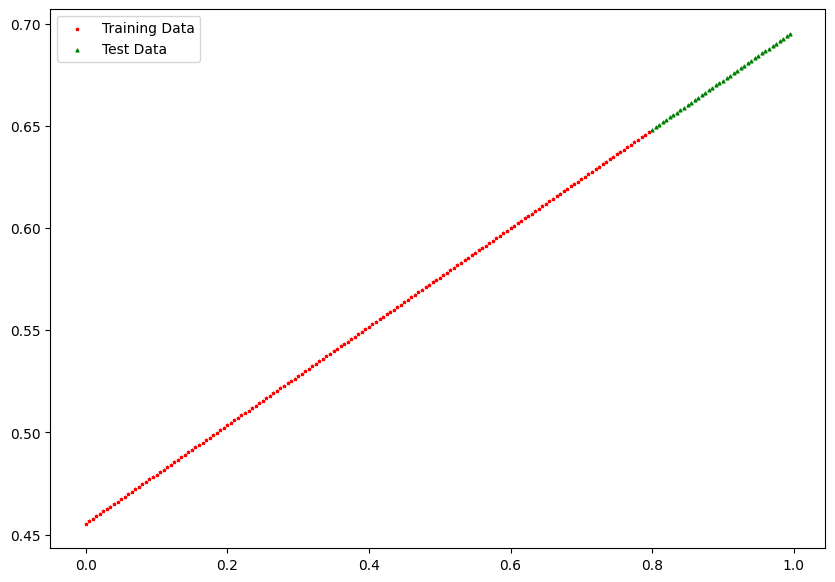

In [5]:
plot_predictions(x_train, y_train, x_test, y_test)

## Build Model

What model does?

1. set random weight and bias at begining
2. adjust those values to be better represent

How does it do so?

1. Gradient Descent (needed requires_grad to be True)
2. Backpropagation

In [6]:
# Create linear regresion model class which extends nn.Module
class LinearRegressionModel(nn.Module):
  # constructor
  def __init__(self, manual_seed=None):
    super().__init__()

    if(manual_seed is not None):
        torch.manual_seed(manual_seed)

    # random weight and will be adjusted
    self.weight = nn.Parameter(
        torch.randn(1, requires_grad=True, dtype=torch.float)
        )

    # random bias and will be adjusted
    self.bias = nn.Parameter(
        torch.randn(1, requires_grad=True, dtype=torch.float)
        )

  # Forward method to define the computation in model
  # This function needed to be overide
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- x would be our train data
    return self.weight * x + self.bias

`note:` The essentials things to build PyTorch model are:

1. torch.nn - contains all of the buildings for computational neural network
2. torch.nn.Parameter - parameters what will be evaluate by ANN
3. torch.nn.Module - The base class for all neural network modules. Subclass of this class must be overide `forward` function.
4. torch.optim - optimizer of ANN that will help with gradient descent

In [7]:
# create instance of LinearRegressionModel
linreg_model_0 = LinearRegressionModel(127489)

# get parameter of the model
print(list(linreg_model_0.parameters()))
print(linreg_model_0.state_dict())

[Parameter containing:
tensor([0.0019], requires_grad=True), Parameter containing:
tensor([0.4031], requires_grad=True)]
OrderedDict([('weight', tensor([0.0019])), ('bias', tensor([0.4031]))])


`note:` The main idea of deep learning in this case is make random weight and bias in model to have same value with weight and bias of our defined variables before (see on first cell of "**Preparing data and load the data**" topic)

## Making Prediction

In [8]:
with torch.inference_mode(): # using this made prediction a lot faster because reduce unnecessery things
  y_preds = linreg_model_0(x_test)

y_preds[:5], y_test[:5]

(tensor([0.4046, 0.4046, 0.4046, 0.4046, 0.4047]),
 tensor([0.6481, 0.6493, 0.6505, 0.6517, 0.6529]))

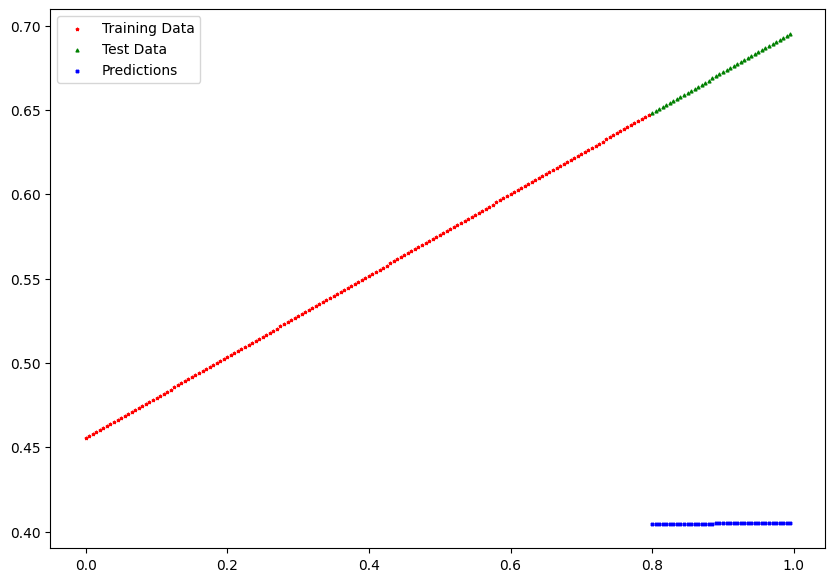

In [9]:
# visualize
plot_predictions(x_train, y_train, x_test, y_test, y_preds)

## Train Model

Things that need to train:

1. [**Loss Function**](https://pytorch.org/docs/stable/nn.html#loss-functions): A function to measure how wrong model's prediction are to the ideal outputs (our purpose for training is to taking this value as minimum as posible)
2. [**Optimizer**](https://pytorch.org/docs/stable/optim.html#algorithms): Takes into account the loss of a model and adjust the model parameters (e.g. weight & bias)

In [10]:
# Setup Loss Function
loss_fn = nn.L1Loss()

# Setup Loss Optimizer
optimizer = torch.optim.SGD(
      params=linreg_model_0.parameters(), # adjusted parameter
      lr = 0.001 # learning rate
    )

### Building a training loop (and a testing loop)

what's a single data need to do:
1. Forward pass (call forward function)
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimizer zero grad
4. Loss backward or move backwards through NN to calculate the gradients for each parameters (**backpropagation**)
5. Optimize parameters (**gradient descents**)

In [11]:
epochs = 250

# Experiment Variables
epoch_count = []
loss_train_count = []
loss_test_count = []

# loop through data
for epoch in range(epochs):

  # set the model to traingin mode
  linreg_model_0.train() # set all parameter to requires_gradient True

  # 1. Forward pass
  y_pred = linreg_model_0.forward(x_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  # MONITORING
  if(epoch % 10 == 0):
    # save the experiment variables
    epoch_count.append(epoch)
    loss_train_count.append(loss)

    # turn off gradient tracking
    linreg_model_0.eval()

    with torch.inference_mode():
      y_pred_test = linreg_model_0.forward(x_test)
      loss_test = loss_fn(y_pred_test, x_test)

      loss_test_count.append(loss_test) # save tje experiment variable
      print(f"epoch: {epoch} | loss: {loss_test} | param: {linreg_model_0.state_dict()}")

epoch: 0 | loss: 0.49133676290512085 | param: OrderedDict([('weight', tensor([0.0023])), ('bias', tensor([0.4041]))])
epoch: 10 | loss: 0.4777693748474121 | param: OrderedDict([('weight', tensor([0.0063])), ('bias', tensor([0.4141]))])
epoch: 20 | loss: 0.4642019271850586 | param: OrderedDict([('weight', tensor([0.0103])), ('bias', tensor([0.4241]))])
epoch: 30 | loss: 0.4506344795227051 | param: OrderedDict([('weight', tensor([0.0142])), ('bias', tensor([0.4341]))])
epoch: 40 | loss: 0.43706709146499634 | param: OrderedDict([('weight', tensor([0.0182])), ('bias', tensor([0.4441]))])
epoch: 50 | loss: 0.4234996438026428 | param: OrderedDict([('weight', tensor([0.0222])), ('bias', tensor([0.4541]))])
epoch: 60 | loss: 0.4103739261627197 | param: OrderedDict([('weight', tensor([0.0262])), ('bias', tensor([0.4636]))])
epoch: 70 | loss: 0.39834505319595337 | param: OrderedDict([('weight', tensor([0.0301])), ('bias', tensor([0.4721]))])
epoch: 80 | loss: 0.3873719274997711 | param: OrderedD

### Visualize, visualize, visualize

In [12]:
def plot_experiment_var(data:list[dict], title=None):
  plt.figure(figsize=(10,7))

  for d in data:
    plt.plot(d["x"], d["y"], label=d["label"])

  if title is not None:
    plt.title(title)

  plt.legend()

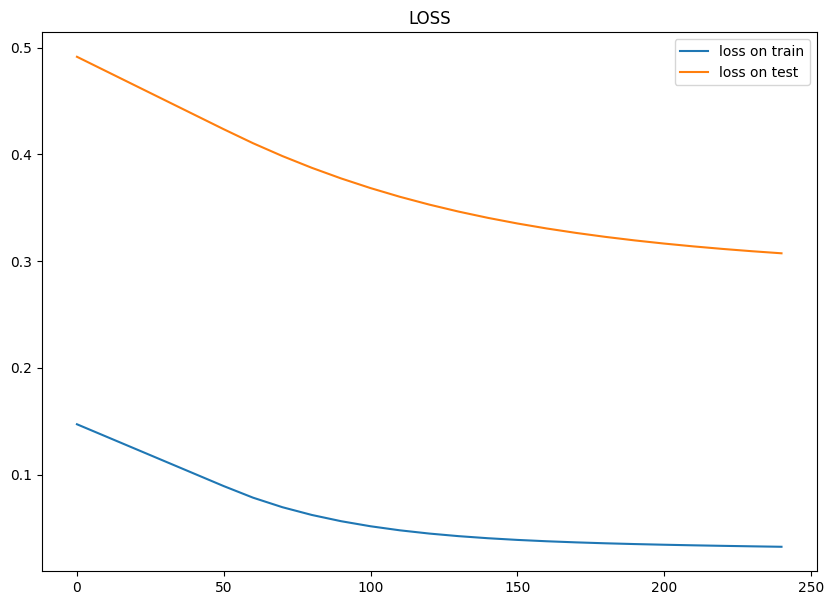

In [14]:
with torch.inference_mode():
  plot_experiment_var(
      [
        {
            "x": epoch_count,
            "y": loss_train_count,
            "label": "loss on train"
        },
        {
            "x": epoch_count,
            "y": loss_test_count,
            "label": "loss on test"
        }
      ],
      title="LOSS"
    )

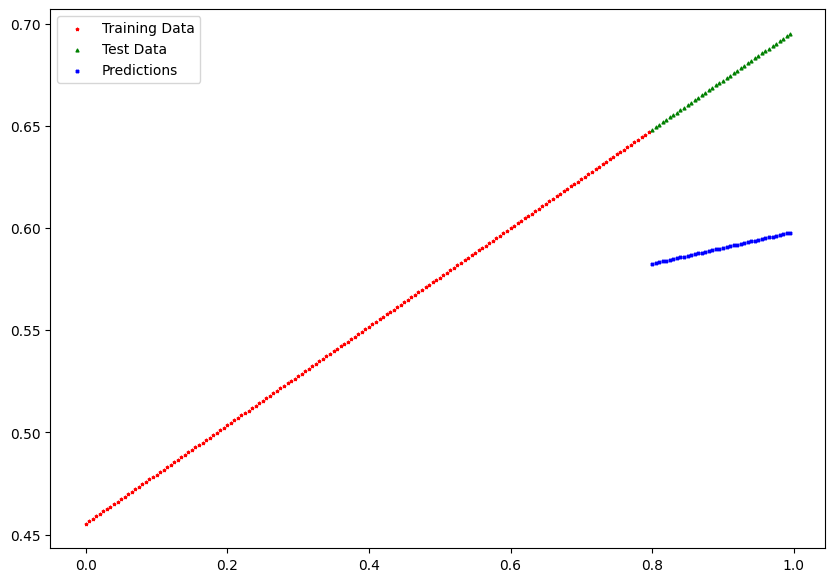

In [15]:
plot_predictions(x_train, y_train, x_test, y_test, y_pred_test)

## Saving & Loading Model

doc: https://pytorch.org/tutorials/beginner/saving_loading_models.html

Main function used for saving loading model:

1. `torch.save()` - save model or state_dict into Python pickle format
2. `torch.load()` - load saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load model's saved state dictionary

### Save model

In [16]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_linreg_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"path: {MODEL_SAVE_PATH}")

# 3. Save the model state
torch.save(obj=linreg_model_0.state_dict(), f=MODEL_SAVE_PATH)
print("Succesfully saving the model")

path: models/pytorch_linreg_model_0.pt
Succesfully saving the model


### Load model

In [17]:
# Load first assign then
linreg_0_state_dict = torch.load(MODEL_SAVE_PATH)

linreg_model_1 = LinearRegressionModel()
linreg_model_1.load_state_dict(linreg_0_state_dict)
print(f"loaded state  : {linreg_model_1.state_dict()}")
print(f"original state: {linreg_model_0.state_dict()}")

loaded state  : OrderedDict([('weight', tensor([0.0804])), ('bias', tensor([0.5196]))])
original state: OrderedDict([('weight', tensor([0.0804])), ('bias', tensor([0.5196]))])


### Another method

In [18]:
targeted_save_state = {
    "model_state": linreg_model_0.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}

# PATH variables
STATE_FILENAME = Path("linreg_model_0_bundle.pt")
DIR_PATH = Path("models")
FILE_PATH = DIR_PATH / STATE_FILENAME

DIR_PATH.mkdir(parents=True, exist_ok=True)

print(f"path: {FILE_PATH}")

torch.save(obj=targeted_save_state, f=FILE_PATH)
print("succesfully save the model's states")

path: models/linreg_model_0_bundle.pt
succesfully save the model's states


In [19]:
print(f"load the model's states: {FILE_PATH}")

loaded_state = torch.load(FILE_PATH)

print(f"loaded state  : {loaded_state}")
print(f"original state: {targeted_save_state}")

load the model's states: models/linreg_model_0_bundle.pt
loaded state  : {'model_state': OrderedDict([('weight', tensor([0.0804])), ('bias', tensor([0.5196]))]), 'optimizer_state': {'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}}
original state: {'model_state': OrderedDict([('weight', tensor([0.0804])), ('bias', tensor([0.5196]))]), 'optimizer_state': {'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}}


#### Load to another device

In [20]:
print(f"load the model's states to cuda: {FILE_PATH}")

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loaded_state = torch.load(FILE_PATH, map_location=DEVICE)

print(f"loaded state  : {loaded_state}")
print(f"original state: {targeted_save_state}")

load the model's states to cuda: models/linreg_model_0_bundle.pt
loaded state  : {'model_state': OrderedDict([('weight', tensor([0.0804], device='cuda:0')), ('bias', tensor([0.5196], device='cuda:0'))]), 'optimizer_state': {'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}}
original state: {'model_state': OrderedDict([('weight', tensor([0.0804])), ('bias', tensor([0.5196]))]), 'optimizer_state': {'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}}
